# Poisson Equation

In [119]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.linalg as la
from scipy.sparse import csr_matrix
from mpl_toolkits.mplot3d import Axes3D

In [7]:
%matplotlib notebook

## Problem 1

Complete the function `poisson_square` by implementing the finite difference method

$$AU + p + q = f$$

where the matrix $A$ and the vectors $p$ and $q$ are defined following (1.4). Construct $A$ as a sparse matrix. Use your function to solve the BVP

$$\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
\end{align}$$

Plot the solution in 3D with $n=100$.

Hint: the function `scipy.sparse.spdiags` will be useful in constructing $A$. Use the function `scipy.sparse.linalg.spsolve` to solve the linear system $AU = f - p - q$.

In [227]:
def poisson_square(a,b,c,d,n,f,g):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        n (int): number of subintervals
        f (function): right-hand side of the PDE
        g (function): boundary condition
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    x = np.linspace(a, b, n+1)
    y = np.linspace(c, d, n+1)
    h = x[1] - x[0]
    
    T = diags([1, -4, 1], [-1, 0, 1], shape=((n-1), (n-1))).toarray()
    M = csr_matrix(la.block_diag(*[T for _ in range(n-1)]))
    I = diags([1, 1], [-(n-1), n-1], shape=((n-1)**2, (n-1)**2))
    A = csr_matrix(M + I)
    
    P = np.zeros((n-1, n-1))
    P[:, 0] = g(np.ones(n-1)*x[0], y[1:-1])
    P[:, -1] = g(np.ones(n-1)*x[-1], y[1:-1])
    P = P.flatten()
    
    Q = np.zeros((n-1, n-1))
    Q[0] = g(x[1:-1], np.ones(n-1)*y[0])
    Q[-1] = g(x[1:-1], np.ones(n-1)*y[-1])
    Q = Q.flatten()
    
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    F = f(X, Y).flatten() * h**2
    
    X, Y = np.meshgrid(x, y)
    U = g(X, Y)
    U_ = spsolve(A, F - P - Q)
    U_ = U_.reshape((n-1, n-1))
    
    U[1:-1, 1:-1] = U_
    return U

    

<IPython.core.display.Javascript object>


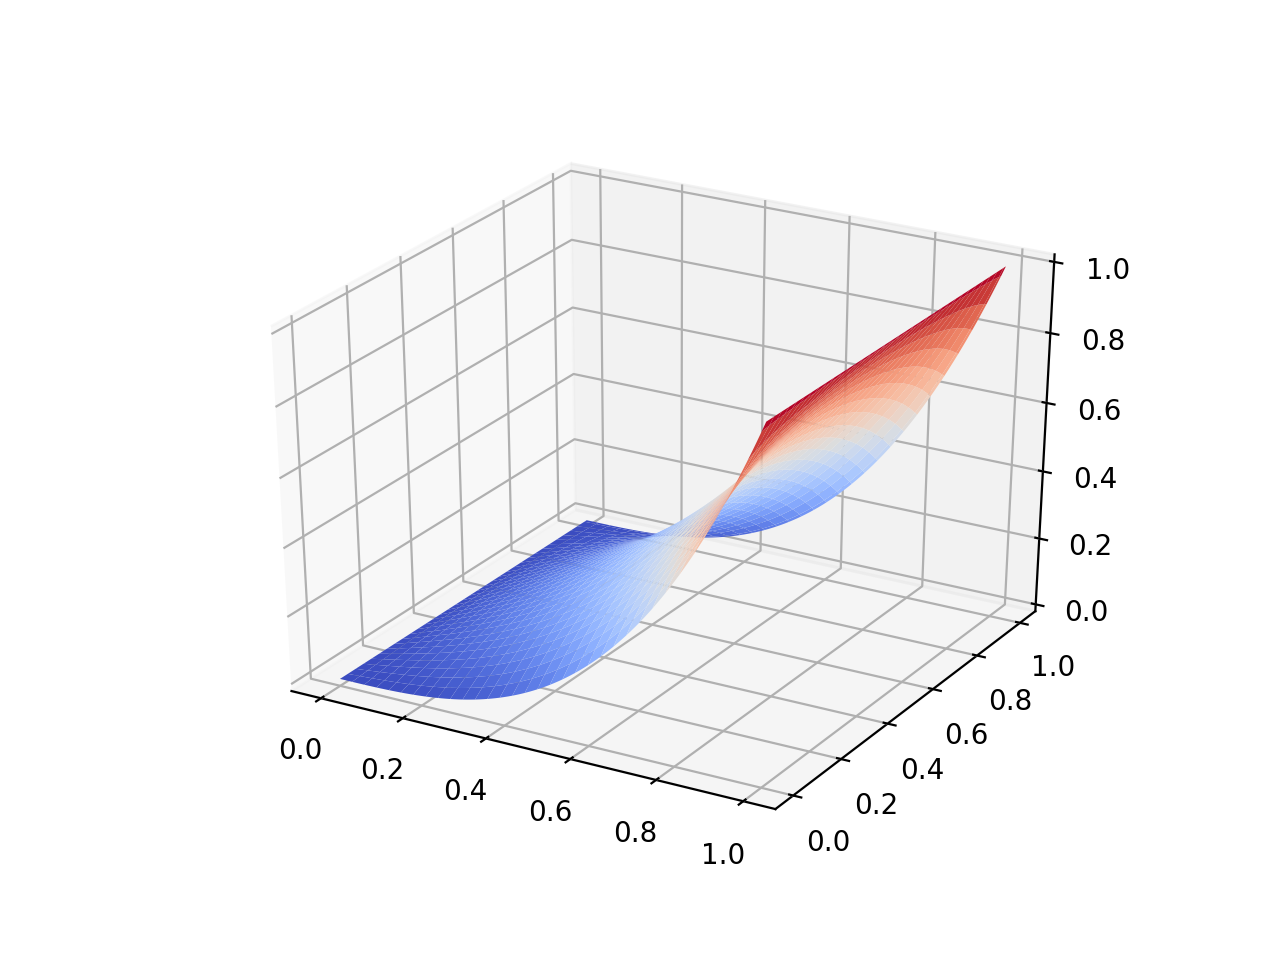

In [228]:
a, b, c, d = 0, 1, 0, 1
f = lambda x,y: x*0 + y*0
g = lambda x,y: x**3 + y*0
n = 100

U = poisson_square(a, b, c, d, n, f, g)

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.linspace(a, b, n+1)
y = np.linspace(c, d, n+1)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, U, cmap="coolwarm")
plt.show()

## Problem 2

Solve 
\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	V(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}
for the electric potential $V.$ Use the source function ($-\rho$) defined below. Plot the solution in 2D with $n=100$.

<IPython.core.display.Javascript object>


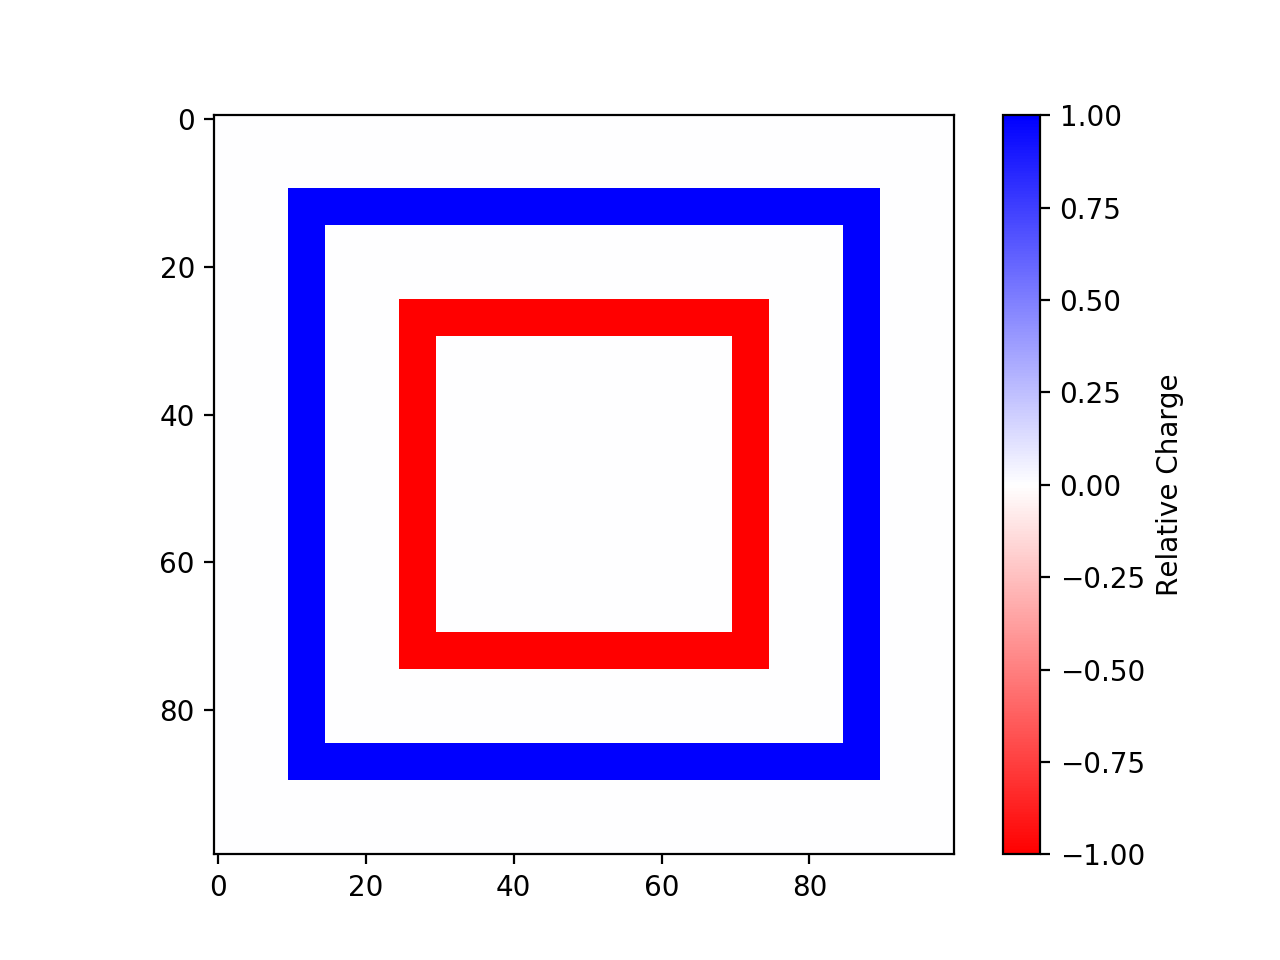

In [165]:
def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
def genDict(data):
    """Generate a color dictionary for use with LinearSegmentedColormap
    that places red and blue at the min and max values of data
    and white when data is zero
    """
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

fig = plt.figure()
plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

<IPython.core.display.Javascript object>


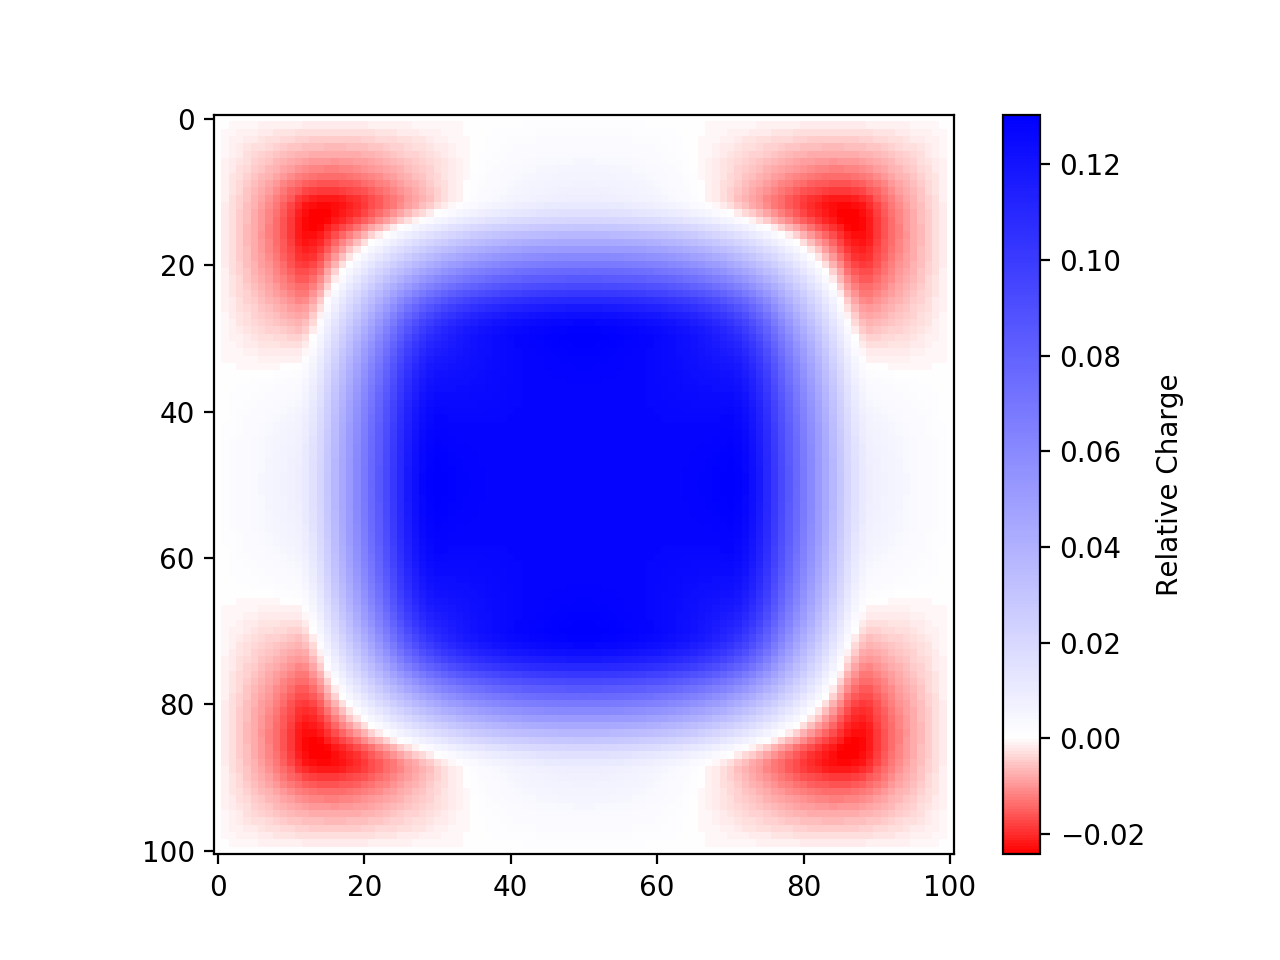

In [229]:
a, b, c, d = -2, 2, -2, 2
g = lambda x,y: x*0 + y*0
n = 100

U = poisson_square(a, b, c, d, n, source, g)

X = np.linspace(a,b,n)
Y = np.linspace(c,d,n)
X,Y = np.meshgrid(X,Y)

fig = plt.figure()
plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Relative Charge")
plt.show()